# Thiết kế Python script cho phân tích thống kê

### BS. Lê Ngọc Khả Nhi

# Giới thiệu

Trong các khóa học về thống kê với Python, người học thường được giảng viên hướng dẫn thực hành trên notebook, thông qua các hàm và câu lệnh tuần tự. Tuy nhiên, khi làm việc trên thực tế thì lại khác - như Nhi đã có lần nói, vì các chuyên viên thường triển khai kế hoạch phân tích dựa trên module và script.

Trong bài hôm nay, Nhi sẽ trình diễn một thí dụ minh họa đơn giản về cách thiết kế modules/script, và thi hành script từ jupyter notebook hoặc CommandLine.

# Bài toán minh họa

Tình huống giả định như sau: Một bác sĩ muốn thực hiện một phân tích thống kê trên bộ dữ liệu Fertility, gồm 10 biến số khảo sát đặc tính của nang noãn, một số hormone, số lượng trứng và phôi... trên 333 phụ nữ có vấn đề về khả năng thụ thai.

Kế hoạch phân tích rất đơn giản sẽ gồm 2 bước: Đầu tiên dùng kỹ thuật K-means clustering để phân chia tối ưu dữ liệu thành 2 phân cụm, sau đó làm một thống kê mô tả và kiểm định t student để so sánh giá trị trung bình 10 biến giữa 2 phân cụm.

Tuy công việc rất đơn giản, nhưng Nhi đã thiết kế cho thí nghiệm này hẳn một package gồm 5 modules lần lượt có vai trò như sau:

# Cấu trúc modules

In [1]:
import os
path = os.getcwd()

from constants import show_dir

In [2]:
show_dir(path)

|__KMC_demo/
    |__constants.py
    |__data_preparation.py
    |__descriptive.py
    |__KmeansCluster_demo.ipynb
    |__kmeans_cluster.py
    |__main.py
   |__.ipynb_checkpoints/
        |__KmeansCluster_demo-checkpoint.ipynb
   |__Graph/
   |__img/
        |__CLI_output.png
        |__Excel_table.png
   |__Output/
   |____pycache__/
        |__constants.cpython-38.pyc


1) **Module constants** chứa những thông số kỹ thuật cho thí nghiệm,  bao gồm đường link đến dữ liệu, 1 dictionary cho phép dịch những tên biến thành tiếng Việt, 1 phổ màu cho biến nhị phân (2 phân cụm). Khi import module này, nó cũng sẽ tự động tạo ra 2 thư mục Graphs và Output để chứa biểu đồ và bảng kết quả.

In [ ]:
import os

df_link = 'https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Fertility.csv'

col_names = {'Age':'Tuổi', 
             'LowAFC': 'Số nang nhỏ nhất', 
             'MeanAFC': 'Số nang trung bình', 
             'FSH': 'Đỉnh FSH',
             'E2':'Mức sinh sản', 
             'MaxE2':'Mức sinh sản tối đa',
             'MaxDailyGn':'Đỉnh Gonadotropin hằng ngày',
             'TotalGn':'Gonadotropin tổng', 
             'Oocytes':'Số lượng trứng', 
             'Embryos':'Số lượng phôi',}

bicolor_pal = ['#e6154c','#0e89ed']

def show_dir(path: str):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 3 * (level) + '|__'
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1) + '|__'
        for fname in files:
            print(f"{subindent}{fname}")

cur_path = os.getcwd()
viz_folder = os.path.join(cur_path, 'Graph')
output_folder = os.path.join(cur_path, 'Output')

if os.path.isdir(viz_folder):
    pass
else:
    os.mkdir(viz_folder)

if os.path.isdir(output_folder):
    pass
else:
    os.mkdir(output_folder)

Tiếp theo, module **data_preparation** chỉ chứa 1 hàm duy nhất là data_generation, chức năng của nó là tải bộ dữ liệu csv từ internet, tạo 1 phiên bản hoán chuyển minmax dùng cho thuật toán phân cụm, và xuất ra 2 dataframes này

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from constants import *

def data_generation(df_link: str):
    '''Hàm tải data và chuẩn hóa thang đo
    :df_link: link đến file csv (str)
    :output: 2 dataframes (gốc và hoán chuyển min/max)
    '''
    df = pd.read_csv(df_link,sep = ',', index_col=0)
    scaler = MinMaxScaler()
    
    t_df = df.copy()
    t_df.loc[:] = scaler.fit_transform(df)

    print("Thực hiện tải dữ liệu và hoán chuyển Min-Max")

    return df, t_df

Module thứ 3, **kmeans_cluster** có vai trò thực hiện phân tích cụm, bên trong nó có 2 hàm:

Hàm Elbow_plot vẽ biểu đồ Elbow để chứng minh số phân cụm = 2 là tối ưu, biểu đồ này sẽ được lưu lại trong thư mục Graph ở định dạng SVG (hình vector).

Hàm kmeans_cluster sẽ thực hiện phân tích cụm trên dữ liệu và xuất ra kết quả là 1 chuỗi các nhãn cho 2 phân cụm 0/1 và 1 array các centroids

In [ ]:
import os
import pandas as pd
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 10})

from constants import *

def Elbow_plot(t_df:None) -> None:
    '''Vẽ biểu đồ Elbow để xác định số phân cụm tối ưu
    '''
    wcss = []

    for i in range(1,7):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=123)
        kmeans.fit(t_df)
        wcss.append(kmeans.inertia_)

    plt.rcParams["figure.figsize"] = (8,6)
    plt.rcParams.update({'font.size': 14})

    plt.plot(range(1, 7), wcss)
    plt.title('Số phân cụm tối ưu = 2')
    plt.vlines(2,ymin=min(wcss),ymax=max(wcss),linestyles='dashed',color='k',alpha = 0.5)
    plt.hlines(wcss[1],xmin= 1,xmax=6,linestyles='dashed',color='k',alpha = 0.5)
    plt.scatter(2,wcss[1],s=50)
    plt.xlabel('Số phân cụm')
    plt.ylabel('Within-Cluster-Sum-of-Squares')
    plt.xticks(range(1,7))

    fig_name = os.path.join(viz_folder, f"Elbow_plot.svg")
    plt.savefig(fname = fig_name, format = 'svg', dpi = 300)

    plt.show()

def kmeans_cluster(t_df: pd.DataFrame, k = 2):
    '''Phân cụm dataframe
    :t_df: dataframe đã chuẩn hóa,
    :k: số phân cụm mong muốn

    :Output: 2 np.array: chuỗi labels và centroids
    '''
    kmeans = KMeans(n_clusters=k, 
                    init='k-means++', 
                    max_iter=300, 
                    n_init=10, 
                    random_state=123)

    pred_y = kmeans.fit_predict(t_df)
    centroids = kmeans.cluster_centers_

    print('Đã thực hiện phân cụm')

    return pred_y, centroids

Module thứ 4: **descriptive**, có vai trò thực hiện thống kê mô tả thông qua 2 hàm:

Hàm describe_clusters sẽ tạo ra 1 dataframe có index là tên 10 biến bằng tiếng Việt, và 3 cột lần lượt là Trung bình +/- sd cho Toàn thể 333 phụ nữ, phân cụm 1 và phân cụm 2, và cột thứ 4 trình bày giá trị p của kiểm định t nhằm so sánh trung bình giữa 2 phân cụm. Dataframe này sẽ được in ra màn hình và đồng thời lưu lại thành 1 file excel trong thư mục Output.

Hàm plot_kde sẽ vẽ 1 biểu đồ pairplot với 1D và 2D KDE cho 10 biến, nhẳm khảo sát trực quan phân bố của 10 biến giữa 2 phân cụm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import pingouin as pg
from constants import *

def describe_clusters(df:pd.DataFrame, labs: np.array, dec:int)->None:
    '''Lập bảng so sánh 10 biến giữa 2 phân cụm
    :df: dataframe dữ liệu gốc,
    :labs: chuỗi labels cho 2 phân cụm
    :dec: số lẻ cho việc làm tròn

    Kết quả là 1 dataframe bảng thống kê mô tả và kiểm định t, 
    sao lưu trong thư mục Output
    ''' 

    df['C'] = labs

    res_df = df.groupby('C').agg(lambda x: f"{np.round(np.mean(x),dec)} ± {np.round(np.std(x),dec)}").T
    res_df.columns = ['Cụm 1', 'Cụm 2']

    res_df['Toàn thể'] = df.agg(lambda x: f"{np.round(np.mean(x),dec)} ± {np.round(np.std(x),dec)}").T

    res_df = res_df[['Toàn thể', 'Cụm 1', 'Cụm 2']]

    p_val = []

    for v in res_df.index:
        p = pg.ttest(df[df['C'] == 0][v], df[df['C']==1][v], tail='one-sided')['p-val'][0]
        p_val.append(p)

    res_df['Giá trị p'] = p_val

    res_df.index = res_df.index.map(col_names)

    print('Kết quả thống kê mô tả 2 phân cụm:')
    print('='*30)
    print(res_df.to_string())

    csv_name = os.path.join(output_folder, f"Table.xlsx")

    res_df.to_excel(csv_name, index = True, encoding='utf-8')
    
def plot_kde(df: pd.DataFrame, labs: np.array)->None:
    '''Vẽ pairplot khảo sát tương quan và phân bố của 10 biến
    :df: dataframe gốc
    :labs: chuỗi labels phân cụm
    '''
    df.columns = df.columns.map(col_names)
    df['C'] = labs
    sns.set_palette(sns.color_palette(bicolor_pal))

    sns.pairplot(data = df, 
             kind = 'kde', 
             diag_kind='hist',
             hue = 'C',
             plot_kws={'shade':True, 'alpha': 0.3}
             )
    
    fig_name = os.path.join(viz_folder, f"KDE_plot.svg")
    plt.savefig(fname = fig_name, format = 'svg', dpi = 300)

# Script hay module main

Như các bạn thấy, ngoài 4 modules nêu trên, còn có 1 module thứ 5 tên là main.py, đây là một module đặc biệt vì hàm main bên trong nó có thể được thi hành trực tiếp từ commandline.

In [ ]:
warning_status = "ignore"
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)

from constants import *
from data_preparation import *
from kmeans_cluster import *
from descriptive import *

def main()->None:

    df, t_df = data_generation(df_link)
    odf = df.copy()
    Elbow_plot(t_df)
    labs, centroids = kmeans_cluster(t_df, k = 2)

    describe_clusters(df = df, labs = labs, dec=3)

    plot_kde(df=odf, labs=labs)

if __name__ == '__main__':
    main()

# Thi hành script

Các bạn có thể thi hành trực tiếp file main.py từ commandlines như sau:

![title](img/CLI_output.png)

Ta cũng có thể import main.py như một module trong notebook và chạy hàm main một cách thủ công: Lúc này kết quả sẽ được hiển thị tuần tự trong notebook

In [3]:
import main

Thực hiện tải dữ liệu và hoán chuyển Min-Max


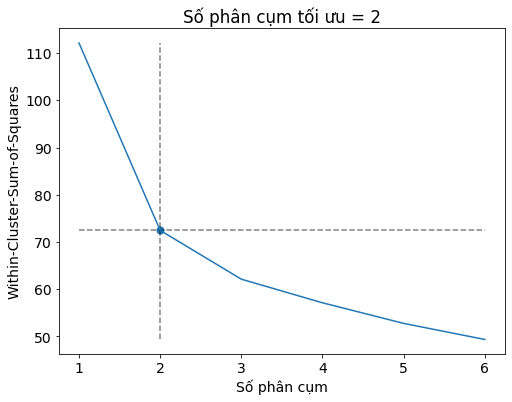

Đã thực hiện phân cụm
Kết quả thống kê mô tả 2 phân cụm:
                                        Toàn thể               Cụm 1               Cụm 2      Giá trị p
Tuổi                              35.333 ± 4.691      38.319 ± 3.747      33.058 ± 4.013   6.796494e-29
Số nang nhỏ nhất                   12.288 ± 6.91       8.667 ± 3.815      15.048 ± 7.446   3.447880e-21
Số nang trung bình                13.529 ± 7.416       9.849 ± 4.277      16.334 ± 8.049   5.712799e-19
Đỉnh FSH                            5.935 ± 1.94        6.97 ± 2.161       5.147 ± 1.279   7.044861e-17
Mức sinh sản                     41.246 ± 15.202     40.931 ± 15.864     41.487 ± 14.672   3.721991e-01
Mức sinh sản tối đa            1546.102 ± 779.65  1276.021 ± 602.704  1751.878 ± 834.444   2.293682e-09
Đỉnh Gonadotropin hằng ngày    310.775 ± 115.598     426.91 ± 49.396     222.291 ± 59.83  3.804301e-110
Gonadotropin tổng            2830.797 ± 1369.726  4094.184 ± 983.365  1868.217 ± 652.805   1.095082e-63
Số lượn

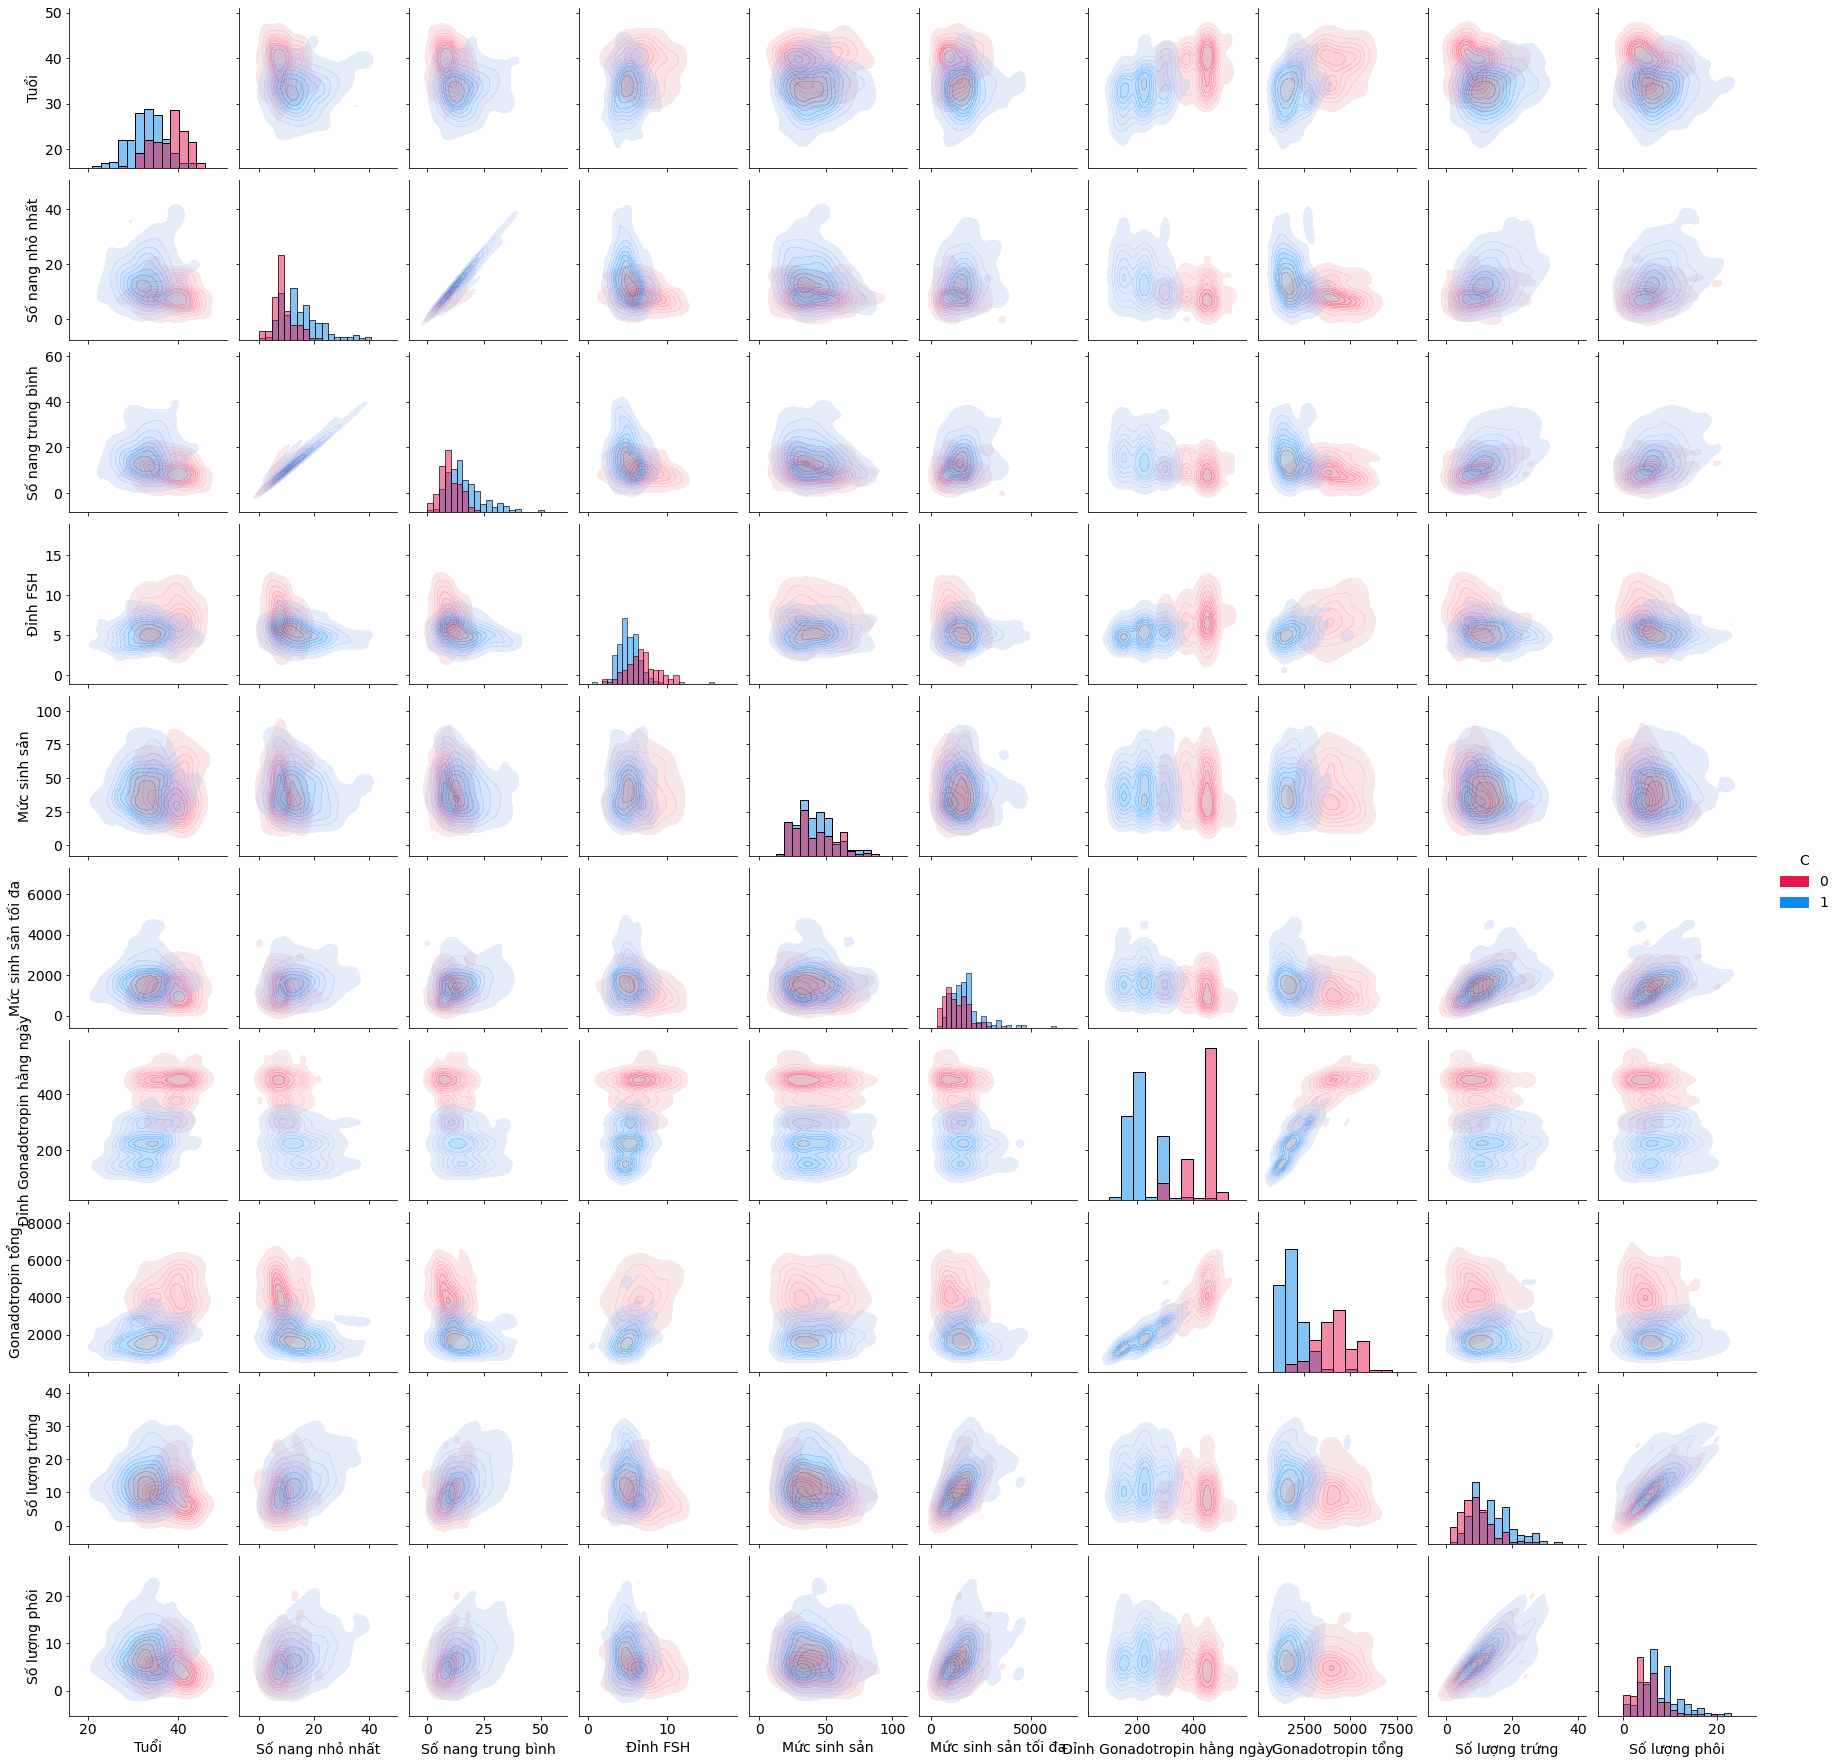

In [4]:
main.main()

Ta kiểm lại sẽ thấy 2 biểu đồ và 1 file Excel đã được lưu lại trong thư mục Graph và Output:

In [5]:
show_dir(path)

|__KMC_demo/
    |__constants.py
    |__data_preparation.py
    |__descriptive.py
    |__KmeansCluster_demo.ipynb
    |__kmeans_cluster.py
    |__main.py
   |__Graph/
        |__Elbow_plot.svg
        |__KDE_plot.svg
   |__img/
        |__CLI_output.png
        |__Excel_table.png
   |__Output/
        |__Table.xlsx


File excel này sau đó có thể được cắt và dán vào báo cáo dễ dàng:

![title](img/Excel_table.png)

# Tổng kết

Bài thực hành đến đây là hết. Dù đây chỉ là một thí dụ đơn giản, các bạn có thể hình dung ra quy trình làm việc trên thực tế của một nhân viên phân tích dữ liệu, cách họ tổ chức code lập trình cho một dự án. Việc tổ chức này tuy có vẻ khó khăn và tốn kém thời gian trong công đoạn chuẩn bị, nhưng lợi ích và hiệu quả của nó hoàn toàn xứng đáng với công sức mà bạn bỏ ra.

Thí dụ: Khi dữ liệu bị thay đổi, và cần thực hiện lại toàn bộ phân tích, bạn có thể làm dễ dàng chỉ với 1 dòng lệnh + một phím Enter từ commandline. Dữ liệu gốc luôn được bảo toàn. Dễ phát hiện sai sót trong các function và nếu có nhu cầu sửa chữa, tùy biến, thay đổi, bạn chỉ phải làm 1 lần duy nhất trong module tương ứng. Nhiều đồng nghiệp có thể cùng hợp tác xây dựng các module trong dự án, thí dụ một người viết hàm đồ họa, 1 người viết hàm để in bảng báo cáo, một người dựng mô hình, vv.

Ngoài ra, bạn cũng có thể hình dung về ranh giới mong manh giữa 2 nghề phân tích dữ liệu và lập trình, sẽ tạo động lực để rèn luyện kỹ năng lập trình của mình ngày càng mạnh hơn.

Ghi chú: Toàn bộ các module có thể tải từ github của Nhi: 

Chúc các bạn thành công.